**Demonstration of various control algorithms for pendulum**

Pavel Osinenko, 2025

$$
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% GENERAL SYMBOLS
\renewcommand{\diff}{\mathop{}\!\mathrm{d}}								      % Differential
\renewcommand{\eps}{{\varepsilon}}										          % Epsilon
\renewcommand{\E}[2][{}]{\mathbb E_{{#1}}\left[#2\right]}					% Mean
\newcommand{\Es}[2][{}]{\hat {\mathbb E}_{{#1}}\left[#2\right]}	% Sample mean
\newcommand{\PP}[1]{\mathbb P\left[#1\right]}							    % Probability
\newcommand{\pdiff}[2]{{\frac{\partial {#1}}{\partial {#2}}}} % Partial diff.
\newcommand{\nrm}[1]{\left\lVert#1\right\rVert}							  % Norm
\newcommand{\abs}[1]{\left\lvert#1\right\rvert}							  % Absolute value
\DeclareMathOperator*{\argmax}{\mathrm{argmax}}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% ARROWS
\newcommand{\ra}{\rightarrow}											% Right arrow
\newcommand{\la}{\leftarrow}											% Left arrow
\newcommand{\rra}{\rightrightarrows}							% Double right arrow
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% ABBREVIATIONS
\newcommand{\sut}{\text{s.}~\text{t.}~}           % "s. t."
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SETS
\newcommand{\N}{{\mathbb{N}}}											% Set of natural numbers
\newcommand{\Z}{{\mathbb{Z}}}											% Set of integer numbers
\newcommand{\Q}{{\mathbb{Q}}}											% Set of rational numbers
\newcommand{\R}{{\mathbb{R}}}											% Set of real numbers
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SYSTEMS AND CONTROL
\newcommand{\state}{s}										% State (as tensor)
\newcommand{\State}{S}										% State (as random variable)
\newcommand{\states}{\mathbb S}						% State space
\newcommand{\action}{a}										% Action (as tensor)
\newcommand{\Action}{A}										% Action (as random variable)
\newcommand{\actions}{\mathbb A}					% Action space
\newcommand{\traj}{z}											% State-action tuple (as tensor tuple)
\newcommand{\Traj}{Z}						% State-action tuple (as random variable tuple)
\newcommand{\obs}{o}											% Observation (as tensor)
\newcommand{\Obs}{O}											% Observation (as random variable)
\newcommand{\obses}{\mathbb O}						% Observation space
\newcommand{\policy}{\pi}									% Policy (as function or distribution)
\newcommand{\policies}{\Pi}								% Policy space
\newcommand{\tfin}{\tau}                 % Final time step or episode length
\newcommand{\transit}{p}									% State transition map
\newcommand{\Transit}{P}									% State transition operator
\newcommand{\reward}{r}										% Reward (as tensor)
\newcommand{\Reward}{R}										% Reward (as random varaible)
\newcommand{\rewardpdf}{p^{\Reward}}			% Reward transition map
\newcommand{\cost}{c}											% Cost (as tensor)
\newcommand{\Cost}{C}											% Cost (as random varaible)
\newcommand{\Value}{v}										% Value
\newcommand{\Advan}{\mathcal A}						% Advantage
\newcommand{\W}{\ensuremath{\mathbb{W}}}	% Weight space
\newcommand{\act}{{\text{act}}}						% Actor abbreviation
\newcommand{\crit}{{\text{crit}}}					% Critic abbreviation
\newcommand{\trajpdf}{\zeta}					    % State-action PDF
\newcommand{\visit}{\rho}					        % State visitation
\newcommand{\surr}{\mathcal{L}}	        % Surrogate objective
% Relative entropy, total variation divergence
\newcommand{\tvdiv}[2]{d_{\text{TV}}\left(#1\;\middle\|\;#2\right)}
\newcommand{\kldiv}[2]{d_{\text{KL}}\left(#1\;\middle\|\;#2\right)}
\newcommand{\barkldiv}[2]{\overline{d}_{\text{KL}}\left(#1 \; \middle\| \; #2\right)}
\newcommand{\maxkldiv}[2]{d^{\max}_{\text{KL}}\left(#1 \; \middle\| \; #2\right)}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% COLORED
\newcommand{\red}[1]{\color{red}{{#1}}}
\newcommand{\blue}[1]{\color{blue}{{#1}}}
\newcommand{\olive}[1]{\color{olive}{{#1}}}
$$

# Problem Statement

# Imports and Globals

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from tqdm import trange   # for a progress bar
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches



# Plant

## Plant Abstraction

In [2]:
class Plant(ABC):
    """
    Abstract base class for any dynamical system (plant).
    Subclasses must define:
        - self.state       (as a NumPy array or list)
        - step(action)     (method to propagate the dynamics)
    """

    @abstractmethod
    def __init__(self, initial_state):
        """
        Initialize the plant with an initial state.
        """
        self.state = np.array(initial_state, dtype=float)

    @abstractmethod
    def step(self, action):
        """
        Step the plant dynamics forward one time increment.
        """
        pass


## Pendulum

In [3]:
class Pendulum(Plant):
    """
    A frictionless pendulum of length l, mass m, state = [theta, theta_dot].
    The action is the torque at the pivot, which is saturable in [-tau_max, +tau_max].
    """

    def __init__(self, initial_state, m=1.0, l=1.0, g=9.81, tau_max=2.0, dt=0.01):
        """
        :param initial_state: [theta0, theta_dot0]
        :param m: mass (kg)
        :param l: length (m)
        :param g: gravitational acceleration
        :param tau_max: maximum absolute torque
        :param dt: integration timestep
        """
        super().__init__(initial_state)
        self.m = m
        self.l = l
        self.g = g
        self.tau_max = tau_max
        self.dt = dt

    def step(self, action):
        # saturate the action (torque)
        torque = np.clip(action, -self.tau_max, self.tau_max)

        theta, theta_dot = self.state

        # Compute angular acceleration (ddtheta)
        ddtheta = - (self.g / self.l) * np.sin(theta) + torque / (self.m * self.l**2)

        # Simple Euler integration
        theta_new = theta + theta_dot * self.dt
        theta_dot_new = theta_dot + ddtheta * self.dt

        # update the state
        self.state = np.array([theta_new, theta_dot_new])


# Controller

## Controller Abstraction

In [4]:
class Controller(ABC):
    """
    Abstract base class for controllers.
    Must define get_action(state).
    """

    @abstractmethod
    def get_action(self, state):
        pass


## PID Controller

In [5]:
class ControllerPID(Controller):
    """
    A simple PID controller for a single-input, single-output scenario.
    """

    def __init__(self, kp, ki, kd, setpoint=0.0, dt=0.01, output_saturation=None):
        """
        :param kp, ki, kd: PID gains
        :param setpoint: the desired setpoint (e.g. 0 for the upright)
        :param dt: timestep
        :param output_saturation: None or (min_val, max_val)
        """
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self.dt = dt

        self.output_saturation = output_saturation

        # Internal states for integral and last error
        self.integral_error = 0.0
        self.last_error = 0.0

    def get_action(self, state):
        """
        For the pendulum, let's interpret 'state' as [theta, theta_dot].
        We'll try to regulate theta to 'setpoint'.
        """
        theta = state[0]
        error = self.setpoint - theta

        # Integrate error
        self.integral_error += error * self.dt

        # Derivative of error
        deriv_error = (error - self.last_error) / self.dt

        # PID output
        output = self.kp * error + self.ki * self.integral_error + self.kd * deriv_error

        # Save current error for next step
        self.last_error = error

        # Saturate if requested
        if self.output_saturation is not None:
            mn, mx = self.output_saturation
            output = np.clip(output, mn, mx)

        return output


## Energy-Based Upswing-Balance Controller

In [6]:
class EnergyPendulumController(Controller):
    """
    A controller that uses energy shaping/bang-bang outside the upright region,
    and a PID inside the upright region for fine balancing.
    """

    def __init__(self, pendulum, pid_controller,
                 energy_torque_limit=None,
                 switch_angle=np.deg2rad(20.0)):
        """
        :param pendulum: the Pendulum object (for parameters m, l, g, tau_max)
        :param pid_controller: instance of ControllerPID
        :param energy_torque_limit: optional float for energy-based torque (<= pendulum.tau_max).
                                     If None, defaults to pendulum.tau_max.
        :param switch_angle: threshold (radians) inside which we switch to PID
        """
        self.pendulum = pendulum
        self.pid_controller = pid_controller
        self.switch_angle = switch_angle

        if energy_torque_limit is None:
            self.energy_torque_limit = pendulum.tau_max
        else:
            self.energy_torque_limit = min(energy_torque_limit, pendulum.tau_max)

    def get_action(self, state):

        def wrap_to_pi(angle):
            # Wrap angle to [-pi, pi]
            return ((angle + np.pi) % (2*np.pi)) - np.pi

        theta, theta_dot = state
        # Decide if we are "close" to upright
        theta_wrapped = wrap_to_pi(theta)
        # print(f'Current angle is {np.rad2deg(theta):.2f}')
        # print(f'Current pi-wrapped angle is {np.rad2deg(theta_wrapped):.2f}')

        if abs( theta_wrapped ) < self.switch_angle:
            # Use PID
            # print(f'Using  PID, current pi-wrapped angle is {np.rad2deg(theta_wrapped):.2f}')
            return self.pid_controller.get_action(state)
        else:
            # Use energy-shaping / bang-bang approach
            # 1) Compute total energy
            m = self.pendulum.m
            l = self.pendulum.l
            g = self.pendulum.g

            E_kin = 0.5 * m * (l**2) * (theta_dot**2)
            E_pot = m * g * l * (1.0 - np.cos(theta))
            E_tot = E_kin + E_pot

            E_des = 2.0 * m*g*l   # Energy for the top (still) position

            # 2) The sign
            sign_term = np.sign( (E_des - E_tot) * theta_dot)  # sgn(E_tot * s_2)

            # print('Using  Energy')

            # 3) Saturate torque with that sign
            return self.energy_torque_limit * sign_term


# Simulation

In [7]:
class Simulation:
    def __init__(self, plant, controller, t_final=5.0):
        """
        :param plant: instance of Pendulum (or any Plant)
        :param controller: instance of Controller
        :param t_final: total time of simulation
        """
        self.plant = plant
        self.controller = controller
        self.t_final = t_final

        # The following will be populated during run()
        self.times = []
        self.states = []
        self.actions = []

    def run(self):
        # We'll compute the number of steps from the plant's dt
        dt = self.plant.dt
        n_steps = int(self.t_final / dt)

        self.times = np.zeros(n_steps+1)
        self.states = np.zeros((n_steps+1, len(self.plant.state)))
        self.actions = np.zeros(n_steps)

        # initial
        self.states[0] = self.plant.state
        for k in trange(n_steps, desc='Simulation'):
            # 1) get action
            action = self.controller.get_action(self.plant.state)

            # 2) step plant
            self.plant.step(action)

            # 3) record
            self.actions[k] = action
            self.states[k+1] = self.plant.state
            self.times[k+1] = (k+1)*dt


# Animator

In [8]:
class Animator:
    def __init__(self, simulation):
        """
        :param simulation: Simulation object (with times, states, actions)
        """
        self.sim = simulation
        self.plant = simulation.plant   # for dimension info
        self.dt = self.plant.dt

        # We'll store figure/animation objects
        self.fig, self.ax = plt.subplots()
        self.line = None
        self.bob = None
        self.torque_arc = None

        # Some settings:
        self.l = self.plant.l
        # We'll define a max arc span in degrees to represent +/− tau_max
        self.max_arc_degs = 140  # just a chosen maximum for visualization
        # radius of the arc around the pivot
        self.arc_radius = 0.3

    def init_animation(self):
        # Setup the axes
        lim = 1.2*self.l
        self.ax.set_xlim(-lim, lim)
        self.ax.set_ylim(-lim, lim)
        self.ax.set_aspect('equal', 'box')
        self.ax.set_title("Pendulum Simulation")

        # Create a pendulum line and a bob marker
        self.line, = self.ax.plot([], [], lw=2)
        self.bob, = self.ax.plot([], [], marker='o', markersize=12)

        # Create an Arc patch for the torque
        # We'll initialize it with zero span and update each frame.
        self.torque_arc = patches.Arc(
            (0, 0),
            self.arc_radius,
            self.arc_radius,
            theta1=0,
            theta2=0,
            lw=2
        )
        self.ax.add_patch(self.torque_arc)

        return (self.line, self.bob, self.torque_arc)

    def update_animation(self, frame_idx):
        """
        Update the line/bob/torque-arc for frame_idx.
        """
        state = self.sim.states[frame_idx]
        action = 0.0
        if frame_idx < len(self.sim.actions):
            action = self.sim.actions[frame_idx]

        theta = state[0]

        # Pendulum tip coordinates
        x = self.l * np.sin(theta)
        y = -self.l * np.cos(theta)

        # Update line (from pivot (0,0) to tip (x,y))
        self.line.set_data([0, x], [0, y])

        # Update bob
        self.bob.set_data([x], [y])

        # Update torque arc
        # The sign of 'action' determines direction (clockwise/counterclockwise).
        # We map torque magnitude to arc degrees.
        tau_max = self.plant.tau_max
        frac = abs(action) / tau_max
        span = self.max_arc_degs * frac  # in degrees

        # We'll define a small function that sets the arc from e.g. (start=0, end=+span) for positive torque
        # or (start=0, end=-span) for negative torque
        if action >= 0.0:
            theta1 = 0
            theta2 = span
        else:
            theta1 = 0
            theta2 = -span

        # Update the patch
        self.torque_arc.theta1 = theta1
        self.torque_arc.theta2 = theta2

        # Optionally rotate the entire arc so it doesn't always start from horizontal
        # but let's keep it simple for demonstration.

        return (self.line, self.bob, self.torque_arc)

    def animate(self):
        # Make a FuncAnimation
        anim = FuncAnimation(
            self.fig,
            self.update_animation,
            frames=len(self.sim.times),
            init_func=self.init_animation,
            interval=1000 * self.dt,  # in ms
            blit=True  # for performance
        )
        # Return HTML5 video for Colab
        return HTML(anim.to_html5_video())

# Run

Simulation: 100%|██████████| 1000/1000 [00:00<00:00, 66911.88it/s]


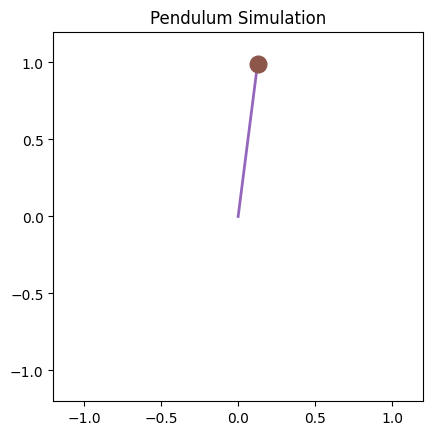

In [9]:
def run_demo():
    initial_state = [-np.pi/2, 0.0]
    pendulum = Pendulum(initial_state, m=1.0, l=1.0, g=9.81, tau_max=0.2, dt=0.02)

    # Create a PID that will hold the pendulum at theta=0 if close
    pid = ControllerPID(kp=20.0, ki=0.5, kd=20.0, setpoint=np.pi, dt=pendulum.dt)

    # Create the combined energy+PID controller
    controller = EnergyPendulumController(pendulum, pid_controller=pid, switch_angle=np.deg2rad(30))

    # Create and run the simulation
    sim = Simulation(pendulum, controller, t_final=20.0)
    sim.run()

    # Animate
    animator = Animator(sim)
    return animator.animate()

animation_html = run_demo()

## Animate

In [10]:
display(animation_html)